In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq
sys.path.insert(0,'/home/gaspar/git/pyhacores/under_construction/fft/')
from under_construction.fft.bit_reversal_fftshift import BitReversal
from under_construction.fft.conjmult import ConjMult
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.windower import Windower
from under_construction.fft.avg_decimate import AvgDecimate
from under_construction.fft.spectrogram import Spectrogram

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db


# Config

In [2]:
fft_points = 256
freq_axis_avg_decimation = 2
extra_sims = []
extra_sims = ['RTL']

# Prepare input

In [3]:
orig_inp = load_iq('/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq')
orig_inp = signal.decimate(orig_inp, 8)
orig_inp *= 0.5

# make sure input divides with fft_points
orig_inp = np.array(orig_inp[:int(len(orig_inp) // fft_points) * fft_points])

# Golden output

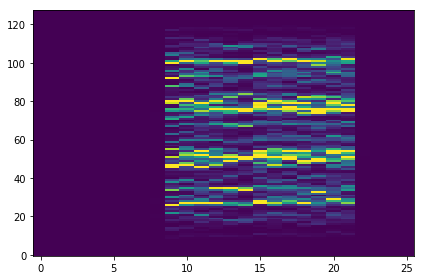

In [4]:
_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

# Apply windowing

In [5]:
dut = Windower(fft_points)

In [6]:
sims = simulate(dut, orig_inp, simulations=['MODEL', 'PYHA'] + extra_sims)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:RTL OK!


/home/gaspar/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


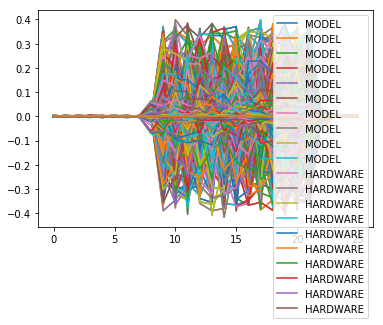

In [7]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [8]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 83.93815096129913


# FFT

In [9]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = R2SDF(fft_points)
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'] + extra_sims)
assert hardware_sims_equal(sims)

# fix fft gain
sims['MODEL'] = np.array(sims['MODEL']) * dut.GAIN_CORRECTION

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:sim:Running COCOTB & GHDL simulation....


ValueError: invalid literal for int() with base 2: 'UUUUUUUUUUUUUUUUUU'

In [ ]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Bit-reversal and fftshift

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = BitReversal(fft_points)
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'] + extra_sims)
assert hardware_sims_equal(sims)


In [ ]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Magnitude

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = ConjMult()
sims = simulate(dut, inp, simulations=['MODEL_PYHA', 'PYHA'] + extra_sims)
assert hardware_sims_equal(sims)

In [ ]:
plt.plot(sims['MODEL_PYHA'], label='MODEL_PYHA')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL_PYHA'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Decimation AVG

In [ ]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = AvgDecimate(freq_axis_avg_decimation)
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'] + extra_sims)
assert hardware_sims_equal(sims)

In [ ]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [ ]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

# Merged object

In [ ]:
inp = orig_inp
dut = Spectrogram(fft_points, decimate_by=freq_axis_avg_decimation)
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'] + extra_sims)
assert hardware_sims_equal(sims)

In [ ]:
x = np.array(sims['RTL']).reshape((-1, fft_points // freq_axis_avg_decimation))
imshow(x.T)

# Final evaluation

In [ ]:
x = np.array(sims['PYHA']).reshape((-1, fft_points // freq_axis_avg_decimation))

In [ ]:
imshow(x.T)

In [ ]:
imshow(golden_output)

In [ ]:
flat_spectro = golden_output.flatten()
flat_spectro /= golden_output.max()

flat_pyha = x.T.flatten()
flat_pyha /= flat_pyha.max()

plt.plot(flat_spectro, label='MODEL_PYHA')
plt.plot(flat_pyha, label='HARDWARE')
plt.legend()
plt.show()

plt.plot(flat_pyha - flat_spectro, label='MODEL_PYHA')
plt.legend()
plt.show()


In [ ]:
snrs = snr(flat_spectro, flat_pyha)
print(f'Block AVG SNR: {snrs}')